<a href="https://colab.research.google.com/github/wilburshi/LogisticRegression_tutorial/blob/main/LogisticRegression_ValueDifference_vs_LogRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression - Value difference v.s. Log Ratio

When fit the behavioral sigmoidal curve using logistic regression, one can assume that value comparison is in the log space, therefore, the value term in the a log ratio. It is also possible that the comparison is the direct difference between values. In this tutorial, we aim to compare the logistic regression with different value terms.

Juice Choice Task (Padoa-Schioppa and Assad, 2006)


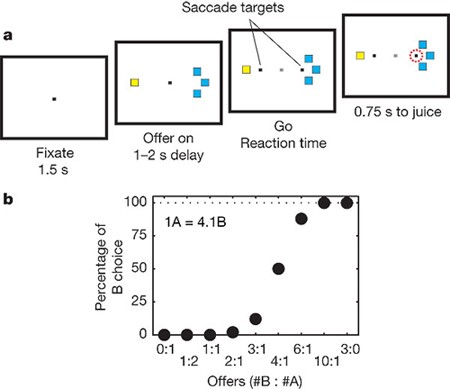

In [ ]:
from IPython.display import Image, display
print('Juice Choice Task (Padoa-Schioppa and Assad, 2006)')
!git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
display(Image('LogisticRegression_tutorial/pics/JC_tasks.jpg', width=400, unconfined=True)) # use it only for google colab 
# display(Image('../pics/JC_tasks.jpg', width=400, unconfined=True))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io import loadmat

## Log Ratio Model

### Step 1: load data

First, let's load example data file named as `goodTrials_JC.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_JC.mat` is a $N \times 4$, where $N$ is the number of the trials in this session, and in this example, $N =176$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 3*: the quantity of juice B. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 4*: the chosen juice type, with 1 indicating A and 2 indicating B.


In [ ]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
data = loadmat('LogisticRegression_tutorial/data/goodtrials_JC.mat')['goodTrials_JC'] # use it only for goole colab
# data = loadmat('../data/goodtrials_JC.mat')['goodTrials_JC'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
triNum = np.abs(data[:,0]) # trial number
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
SideA = np.sign(data[:,1]) # side of target A. -1: left, 1: right, 0 forced choice

# Dependent variables
CJ = data[:,3]-1 # the type of chosen juice. 0: chosen A, 1: chosen B

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) # index of forced choice
ind_nonforced = ~ind_forced

### Step 2: probit regression fitting (log ratio)
we use probit regression to fit the choice pattern. the model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) $

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_A$ and $q_B$ are the juice quantity for A and B in each trial. $a_0$ and $a_1$ are the fitted parameters, from which we define the relative value ($\rho$) between A and B as $\rho = exp(-a_0/a_1)$ and the sigmoid steepness ($\eta$) as $\eta = a_1$. Relative value measures the indifference point at which the value of A and B are the same, that is, $1 q_A = \rho q_B$; steepness reflects the choice accuracy which is inverse to the choice variability.

In [ ]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit

In [ ]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X = np.log(QB[ind_nonforced]/QA[ind_nonforced]) # log ratio
const = np.ones(X.shape)

# probit regression
model = Probit(Y, np.transpose([const, X]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.285275
         Iterations 8


### Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities). We also exclude the forced choice for convenience.

In [ ]:
# We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities)
def OfferTypeTable_LogRatio(alltrials,allchoice):
    # calculate offer types
    table01 = np.unique(alltrials,axis = 1)
    LogRatio = np.log(table01[0,:]/table01[1,:])
    ntritype = np.shape(table01)[1]
    
    # calculate the percentage of choice B #
    PB = np.array([]) # percentage of choice B
    xtickname = np.array([]) # x axis tick names
    for itritype in np.arange(0, ntritype,1):
        ind_itritype = (np.transpose(alltrials) == np.transpose(table01)[itritype,:]).all(axis=1)
        CJ_itritype = allchoice[ind_itritype]
        PB_itritype = np.sum(CJ_itritype)/(np.shape(CJ_itritype)[0])
        PB = np.append(PB,PB_itritype)
        xtickname_itritype = np.array2string(table01[0,itritype])+'/'+np.array2string(table01[1,itritype])
        xtickname = np.append(xtickname,xtickname_itritype)
    
    return (LogRatio, PB, xtickname, table01)

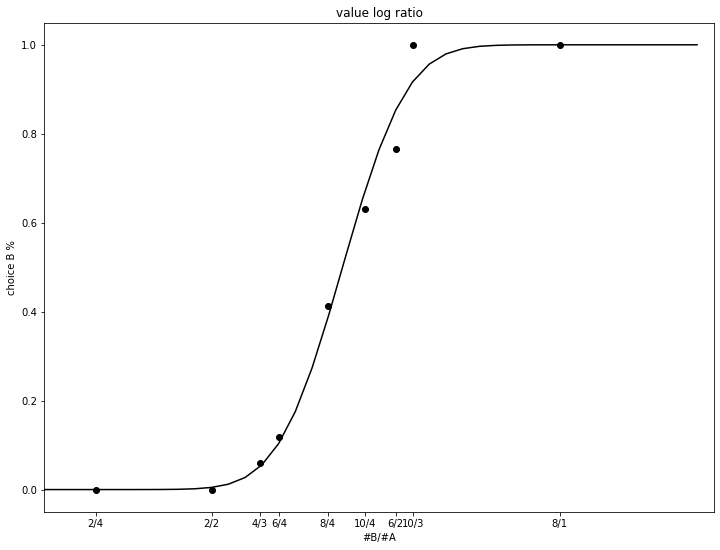

In [ ]:
#####
# plot the results #
#####
(LogRatio, PB, xtickname, table01) = OfferTypeTable_LogRatio([QB[ind_nonforced], QA[ind_nonforced]], CJ[ind_nonforced])

# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio)), np.ceil(np.max(LogRatio)), 0.1)
const_plot = np.ones(np.size(X_plot))
Y_plot = probit_model.predict(np.transpose([const_plot, X_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio,PB, 'ko')
plt.plot(X_plot,Y_plot,'k')
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio)
ax.set_xticklabels(xtickname)
ax.set_title('value log ratio');

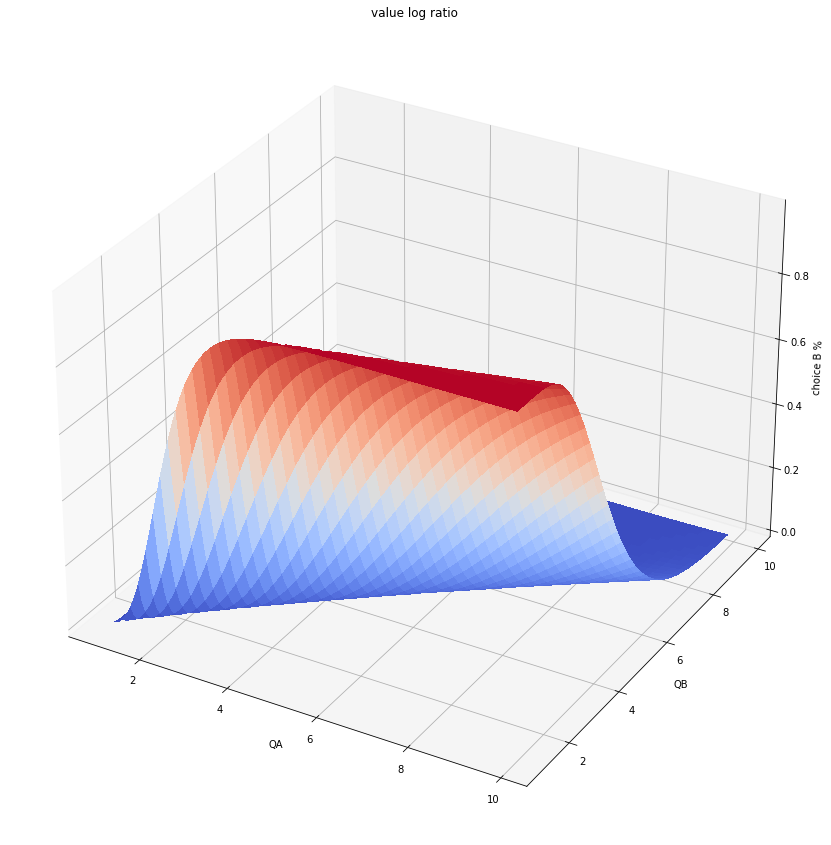

In [ ]:
# plot sigmoidal surface
QA_plot = np.arange(np.floor(np.min(table01[:])), np.ceil(np.max(table01[:])), 0.1)
QB_plot = np.arange(np.floor(np.min(table01[:])), np.ceil(np.max(table01[:])), 0.1)
QA_plot, QB_plot = np.meshgrid(QA_plot, QB_plot)
Y_plot = probit_model.predict(np.transpose([np.ones(np.shape(QA_plot)), np.log(QB_plot/QA_plot)]))

# plot
fig = plt.figure(figsize =(20, 15))
ax = plt.axes(projection ='3d')
surf = ax.plot_surface(QA_plot, QB_plot, Y_plot, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('QA')
ax.set_ylabel('QB')
ax.set_zlabel('choice B %')
ax.set_title('value log ratio');

In [ ]:
rho = np.exp(-betas[0]/betas[1])
print('relative value ρ is: ', np.array2string(rho))
eta = betas[1]
print('steepness η is: ', np.array2string(eta))
model_bic = probit_model.bic
print('model BIC is: ', np.array2string(model_bic))


relative value ρ is:  2.18647539
steepness η is:  3.30671802
model BIC is:  100.85520226


## Value difference model

### Step 1: load data

We will use the same data set

### Step 2: probit regression fitting (with value difference)

Side bias quantifies the bias in favor of one side of the target. The model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 q_A + a_1 q_B$

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_A$ and $q_B$ are the juice quantity for A and B in each trial. $a_0$ and $a_1$ are the fitted parameters, from which we define the relative value ($\rho$) between A and B as $\rho = -a_0/a_1$ and the sigmoid steepness ($\eta$) as $\eta = a_1$. Relative value measures the indifference point at which the value of A and B are the same, that is, $1 q_A = \rho q_B$; steepness reflects the choice accuracy which is inverse to the choice variability.

In [ ]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = QA[ind_nonforced]
X2 = QB[ind_nonforced]

# probit regression
model = Probit(Y, np.transpose([X1, X2]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.295020
         Iterations 7


### Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities). We also exclude the forced choice for convenience.

In [ ]:
# We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities)
def OfferTypeTable_ValueDiff(alltrials,allchoice):
    # calculate offer types
    table01 = np.unique(alltrials,axis = 1)
    ntritype = np.shape(table01)[1]
    
    # calculate the percentage of choice B #
    PB = np.array([]) # percentage of choice B
    xtickname = np.array([]) # x axis tick names
    for itritype in np.arange(0, ntritype,1):
        ind_itritype = (np.transpose(alltrials) == np.transpose(table01)[itritype,:]).all(axis=1)
        CJ_itritype = allchoice[ind_itritype]
        PB_itritype = np.sum(CJ_itritype)/(np.shape(CJ_itritype)[0])
        PB = np.append(PB,PB_itritype)
        xtickname_itritype = np.array2string(table01[0,itritype])+'-'+np.array2string(table01[1,itritype])
        xtickname = np.append(xtickname,xtickname_itritype)
    
    return (table01, PB, xtickname)

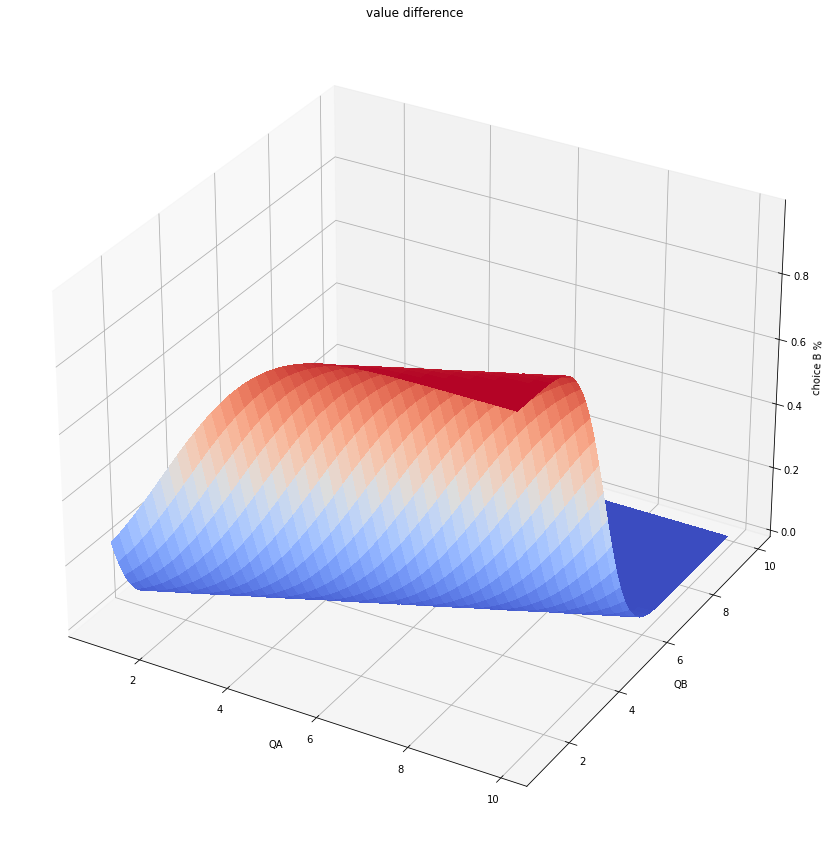

In [ ]:
#####
# plot the results #
#####
(table01, PB, xtickname) = OfferTypeTable_ValueDiff([QB[ind_nonforced], QA[ind_nonforced]], CJ[ind_nonforced])

# plot sigmoidal surface
QA_plot = np.arange(np.floor(np.min(table01[:])), np.ceil(np.max(table01[:])), 0.1)
QB_plot = np.arange(np.floor(np.min(table01[:])), np.ceil(np.max(table01[:])), 0.1)
QA_plot, QB_plot = np.meshgrid(QA_plot, QB_plot)
Y_plot = probit_model.predict(np.transpose([QA_plot, QB_plot]))

# plot
fig = plt.figure(figsize =(20, 15))
ax = plt.axes(projection ='3d')
surf = ax.plot_surface(QA_plot, QB_plot, Y_plot, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('QA')
ax.set_ylabel('QB')
ax.set_zlabel('choice B %')
ax.set_title('value difference');

In [ ]:
rho = -betas[0]/betas[1]
print('relative value ρ is: ', np.array2string(rho))
eta = betas[1]
print('steepness η is: ', np.array2string(eta))
model_bic = probit_model.bic
print('model BIC is: ', np.array2string(model_bic))

relative value ρ is:  2.21750224
steepness η is:  0.54756275
model BIC is:  103.95409039
